# PROJETO 1 - Método do Gradiente Descendente
## Realizado por: Tiago Garcia nº47211, Inês Macedo nº50293, Ricardo Faria nº50834

In [42]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [43]:
######################################################
# 1. Carregar o conjunto de dados (California Housing)
######################################################

# Carrega o dataset "California Housing"
dados = fetch_california_housing(as_frame=False)
X_atributos = dados.data       # matriz de atributos
y_alvo = dados.target          # vetor com o preço médio

# Converter a alvo para vetor coluna
y_alvo = y_alvo.reshape(-1, 1)

print(dados.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [44]:
######################
# 2. Amostra dos dados
######################

# Número total de exemplos no dataset
n_total = X_atributos.shape[0]

# O projeto pede exatamente 1000 exemplos
n_amostra = 1000

np.random.seed(42) # Para garantir resultados iguais em cada execução

# Escolher 1000 índices aleatórios (sem repetição)
indices_amostra = np.random.choice(
    n_total,
    n_amostra,
    replace=False
)
# Criar a amostra final
X_amostra = X_atributos[indices_amostra]
y_amostra = y_alvo[indices_amostra]

In [45]:
###################################################
# 3. Divisão dos dados (Treino / Validação / Teste)
###################################################

# 1ª divisão: 700 treino + 300 temporários (validação + teste)
X_treino, X_temp, y_treino, y_temp = train_test_split(
    X_amostra, y_amostra,
    test_size=300,
    random_state=42
)

# 2ª divisão: dos 300 temporários -> 150 validação + 150 teste
X_validacao, X_teste, y_validacao, y_teste = train_test_split(
    X_temp, y_temp,
    test_size=150,
    random_state=42
)

print("Divisão dos dados:")
print(f"  Treino:     {X_treino.shape[0]}")
print(f"  Validação:  {X_validacao.shape[0]}")
print(f"  Teste:      {X_teste.shape[0]}")

Divisão dos dados:
  Treino:     700
  Validação:  150
  Teste:      150


In [46]:
#########################
# 4. Normalização Z-score
#########################

# A normalização ajuda o gradiente descendente a funcionar melhor

# Criar o normalizador
normalizador = StandardScaler()

# Ajustar o normalizador só com os dados de treino
normalizador.fit(X_treino)

# Aplicar a normalização aos três conjuntos
X_treino_norm = normalizador.transform(X_treino)
X_validacao_norm = normalizador.transform(X_validacao)
X_teste_norm = normalizador.transform(X_teste)

In [47]:
######################################################
# 5. Verificação da Normalização no Conjunto de Treino
######################################################

# No treino, após normalizar, cada atributo deve ter média aprox. 0 e desvio aprox. 1
print("\nMédias após normalização (esperado aprox. 0):")
print(np.mean(X_treino_norm, axis=0))

print("\nDesvios padrão após normalização (esperado aprox. 1):")
print(np.std(X_treino_norm, axis=0))

# A partir daqui usamos:
# X_treino_norm, y_treino
# X_validacao_norm, y_validacao
# X_teste_norm, y_teste


Médias após normalização (esperado aprox. 0):
[ 1.35130002e-15  1.00950994e-16  3.87543172e-15  1.71608759e-15
  8.70732058e-17 -6.94682407e-16  6.58425695e-15  3.30449953e-14]

Desvios padrão após normalização (esperado aprox. 1):
[1. 1. 1. 1. 1. 1. 1. 1.]


In [48]:
##########################################################
# 6. Função para Calcular o Custo (MSE + Regularização L2)
##########################################################

def calcular_custo(X_dados, y_alvo, pesos_W, vies_b, lambda_reg):
    """
    Calcula o custo (loss) da Regressão Linear com regularização L2 (Ridge).

    A função implementa a fórmula:

        J(W, b) = (1/n) * SUM ( (y_previsto_i - y_i)^2 )  +  lambda * SUM (W_j^2)

    onde:
        y_previsto_i = W^T * X_i + b

    Argumentos:
        X_dados     - Matriz de dados (n_exemplos, n_atributos)
        y_alvo      - Vetor de valores reais (n_exemplos, 1)
        pesos_W     - Vetor de pesos (n_atributos, 1)
        vies_b      - Termo de viés (bias) do modelo (escalar)
        lambda_reg  - Parâmetro de regularização L2 (escalar)

    Retorna:
        custo_total - Valor final do custo (loss) calculado (escalar)
    """

    n_exemplos = X_dados.shape[0]

    # Previsões do modelo: y_previsto = XW + b
    y_previsto = np.dot(X_dados, pesos_W) + vies_b

    # Erro quadrático médio (MSE)
    mse = (1 / n_exemplos) * np.sum((y_previsto - y_alvo) ** 2)

    # Termo de regularização L2 (não inclui o viés)
    reg_l2 = lambda_reg * np.sum(pesos_W ** 2)

    # Custo total
    custo_total = mse + reg_l2

    return custo_total

In [49]:
#############################################
# 6.1. Teste simples da função calcular_custo
#############################################

# Criar dados fictícios
X_teste_custo = np.random.rand(10, 3)    # 10 exemplos, 3 atributos
y_teste_custo = np.random.rand(10, 1)    # valores reais
W_teste_custo = np.random.rand(3, 1)     # pesos aleatórios
b_teste_custo = 0.5                       # viés (escalar)
lambda_teste = 0.1                        # regularização

# Calcular o custo com a função criada
custo_inicial = calcular_custo(
    X_teste_custo,
    y_teste_custo,
    W_teste_custo,
    b_teste_custo,
    lambda_teste
)

print("Custo inicial calculado:", custo_inicial)

Custo inicial calculado: 0.5187170711596867


In [50]:
###############################################
# 7. Função para Calcular os Gradientes (W e b)
###############################################

def calcular_gradientes(X_dados, y_alvo, pesos_W, vies_b, lambda_reg):
    """
    Calcula os gradientes da função de custo em relação aos parâmetros W e b.

    Definições:

        y_previsto = X * W + b
        erro       = y_previsto - y

    Fórmulas:

        grad_W = (1/n) * X^T * erro  +  2 * lambda * W
        grad_b = (1/n) * SUM erro

    Argumentos:
        X_dados     - Matriz de dados (n_exemplos, n_atributos)
        y_alvo      - Vetor de valores reais (n_exemplos, 1)
        pesos_W     - Vetor de pesos (n_atributos, 1)
        vies_b      - Termo de viés (bias) do modelo (escalar)
        lambda_reg  - Parâmetro de regularização L2 (escalar)

    Retorna:
        grad_W - Gradiente em relação aos pesos W (n_atributos, 1)
        grad_b - Gradiente em relação ao viés b (escalar)
    """

    n_exemplos = X_dados.shape[0]

    # Previsões do modelo
    y_previsto = np.dot(X_dados, pesos_W) + vies_b

    # Erro: diferença entre previsão e valor real
    erro = y_previsto - y_alvo

    # Gradiente dos pesos
    grad_W = (1 / n_exemplos) * np.dot(X_dados.T, erro) + 2 * lambda_reg * pesos_W

    # Gradiente do viés
    grad_b = (1 / n_exemplos) * np.sum(erro)

    return grad_W, grad_b

In [51]:
##################################################
# 7.1. Teste simples da função calcular_gradientes
##################################################

# Criar dados fictícios
X_teste_grad = np.random.rand(10, 3)
y_teste_grad = np.random.rand(10, 1)
W_teste_grad = np.random.rand(3, 1)
b_teste_grad = 0.5
lambda_teste = 0.1

# Calcular os gradientes
grad_W_teste, grad_b_teste = calcular_gradientes(
    X_teste_grad,
    y_teste_grad,
    W_teste_grad,
    b_teste_grad,
    lambda_teste
)

print("Dimensão de grad_W:", grad_W_teste.shape, "(deve ser igual a W)")
print("Valor de grad_b:", grad_b_teste, "(escalar)")

Dimensão de grad_W: (3, 1) (deve ser igual a W)
Valor de grad_b: 1.1234388925689822 (escalar)


In [52]:
####################################################
# 8. Treino com Gradiente Descendente em Batch (BGD)
####################################################

def gradiente_descendente_batch(X_treino, y_treino,
                                X_validacao, y_validacao,
                                taxa_aprendizagem, lambda_reg, n_epocas):
    """
    Treina um modelo de regressão linear usando Gradiente Descendente em Batch.

    Em cada época:
      - usa TODOS os exemplos de treino de uma vez;
      - calcula o gradiente médio em relação a W e b;
      - atualiza os parâmetros;
      - calcula o custo no treino e na validação.

    Argumentos:
        X_treino        - Matriz de treino (n_exemplos, n_atributos)
        y_treino        - Vetor alvo de treino (n_exemplos, 1)
        X_validacao     - Matriz de validação
        y_validacao     - Vetor alvo de validação
        taxa_aprendizagem - valor da taxa de aprendizagem (η)
        lambda_reg      - parâmetro de regularização L2 (λ)
        n_epocas        - número total de épocas

    Retorna:
        pesos_W         - pesos finais treinados (n_atributos, 1)
        vies_b          - viés final treinado (escalar)
        custos_treino   - lista com o custo de treino por época
        custos_validacao - lista com o custo de validação por época
    """

    n_exemplos, n_atributos = X_treino.shape

    # Inicialização dos parâmetros
    pesos_W = np.random.randn(n_atributos, 1) * 0.01   # pesos pequenos aleatórios
    vies_b = 0.0                                       # viés inicial a 0

    # Listas para guardar a evolução do custo
    custos_treino = []
    custos_validacao = []

    print(f"Iniciar BGD com η={taxa_aprendizagem}, λ={lambda_reg}, épocas={n_epocas}")

    # Ciclo principal de treino
    for epoca in range(n_epocas):

        # 1) Calcular gradientes usando TODOS os dados de treino
        grad_W, grad_b = calcular_gradientes(
            X_treino, y_treino,
            pesos_W, vies_b,
            lambda_reg
        )

        # 2) Atualizar parâmetros
        pesos_W = pesos_W - taxa_aprendizagem * grad_W
        vies_b = vies_b - taxa_aprendizagem * grad_b

        # 3) Calcular custo no treino e na validação
        custo_treino = calcular_custo(X_treino, y_treino, pesos_W, vies_b, lambda_reg)
        custo_validacao = calcular_custo(X_validacao, y_validacao, pesos_W, vies_b, lambda_reg)

        custos_treino.append(custo_treino)
        custos_validacao.append(custo_validacao)

        # Imprimir progresso de vez em quando
        if epoca % 100 == 0 or epoca == n_epocas - 1:
            print(f"Época {epoca+1}/{n_epocas} | "
                  f"Loss Treino: {custo_treino:.4f} | "
                  f"Loss Validação: {custo_validacao:.4f}")

    print("Treino BGD concluído.\n")

    return pesos_W, vies_b, custos_treino, custos_validacao

In [53]:
################################
# 8.1. Executar o Treino com BGD
################################

# Hiperparâmetros para o BGD
taxa_bgd = 0.01       # taxa de aprendizagem (LR)
epocas_bgd = 1000     # número de épocas
lambda_bgd = 0.01     # regularização L2 (Lambda)

# Treinar o modelo BGD com os DADOS NORMALIZADOS
pesos_W_bgd, vies_b_bgd, custos_treino_bgd, custos_validacao_bgd = gradiente_descendente_batch(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_bgd, lambda_bgd, epocas_bgd
)

print("Resultados finais BGD:")
print("  Primeiros 3 pesos:", pesos_W_bgd[:3].flatten())
print(f"  Viés (b): {vies_b_bgd:.4f}")

Iniciar BGD com η=0.01, λ=0.01, épocas=1000
Época 1/1000 | Loss Treino: 5.4469 | Loss Validação: 6.3294
Época 101/1000 | Loss Treino: 1.2136 | Loss Validação: 1.3800
Época 201/1000 | Loss Treino: 0.6403 | Loss Validação: 0.6921
Época 301/1000 | Loss Treino: 0.5498 | Loss Validação: 0.5751
Época 401/1000 | Loss Treino: 0.5279 | Loss Validação: 0.5454
Época 501/1000 | Loss Treino: 0.5176 | Loss Validação: 0.5326
Época 601/1000 | Loss Treino: 0.5105 | Loss Validação: 0.5246
Época 701/1000 | Loss Treino: 0.5050 | Loss Validação: 0.5186
Época 801/1000 | Loss Treino: 0.5005 | Loss Validação: 0.5138
Época 901/1000 | Loss Treino: 0.4969 | Loss Validação: 0.5099
Época 1000/1000 | Loss Treino: 0.4940 | Loss Validação: 0.5067
Treino BGD concluído.

Resultados finais BGD:
  Primeiros 3 pesos: [ 0.767549    0.15624591 -0.05265582]
  Viés (b): 2.0576


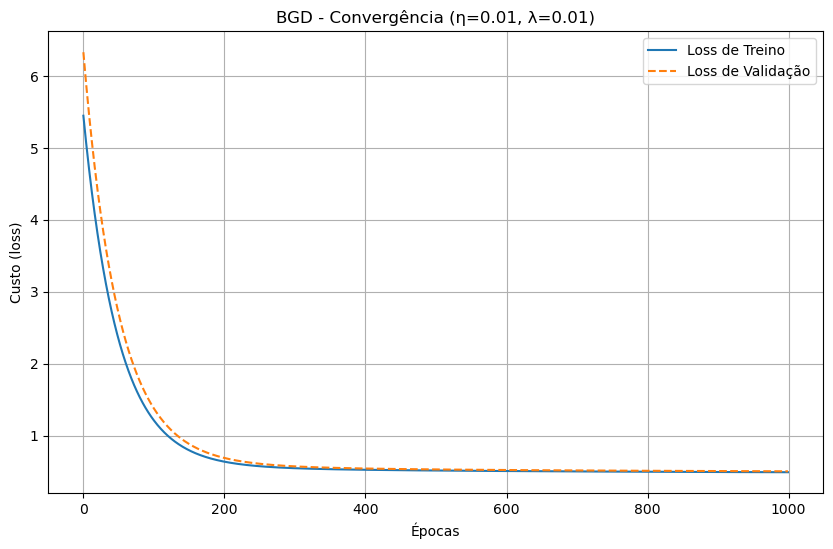

In [54]:
#####################################
# 8.2. Gráfico de Convergência do BGD
#####################################

plt.figure(figsize=(10, 6))
plt.plot(custos_treino_bgd, label="Loss de Treino")
plt.plot(custos_validacao_bgd, label="Loss de Validação", linestyle='--')

plt.title(f"BGD - Convergência (η={taxa_bgd}, λ={lambda_bgd})")
plt.xlabel("Épocas")
plt.ylabel("Custo (loss)")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
#######################################################
# 9. Treino com Gradiente Descendente Estocástico (SGD)
#######################################################

def gradiente_descendente_estocastico(X_treino, y_treino,
                                      X_validacao, y_validacao,
                                      taxa_aprendizagem, lambda_reg, n_epocas):
    """
    Treina um modelo de regressão linear usando Gradiente Descendente Estocástico (SGD).

    Em cada época:
      - baralha os dados de treino;
      - percorre os exemplos um a um;
      - atualiza os pesos e o viés a cada exemplo;
      - no fim da época calcula o custo no treino e na validação.

    Argumentos:
        X_treino         - Matriz de treino (n_exemplos, n_atributos)
        y_treino         - Vetor alvo de treino (n_exemplos, 1)
        X_validacao      - Matriz de validação
        y_validacao      - Vetor alvo de validação
        taxa_aprendizagem - valor da taxa de aprendizagem (η)
        lambda_reg       - parâmetro de regularização L2 (λ)
        n_epocas         - número total de épocas

    Retorna:
        pesos_W          - pesos finais treinados (n_atributos, 1)
        vies_b           - viés final treinado (escalar)
        custos_treino    - lista com o custo de treino por época
        custos_validacao - lista com o custo de validação por época
    """

    n_exemplos, n_atributos = X_treino.shape

    # Inicialização dos parâmetros
    pesos_W = np.random.randn(n_atributos, 1) * 0.01
    vies_b = 0.0

    custos_treino = []
    custos_validacao = []

    print(f"Iniciar SGD com η={taxa_aprendizagem}, λ={lambda_reg}, épocas={n_epocas}")

    # Ciclo principal de treino
    for epoca in range(n_epocas):

        # 1) Baralhar os dados de treino no início da época
        indices_baralhados = np.random.permutation(n_exemplos)
        X_treino_baralhado = X_treino[indices_baralhados]
        y_treino_baralhado = y_treino[indices_baralhados]

        # 2) Percorrer exemplo a exemplo
        for i in range(n_exemplos):
            X_i = X_treino_baralhado[i:i+1]  # mantém forma (1, n_atributos)
            y_i = y_treino_baralhado[i:i+1] # mantém forma (1, 1)

            # Gradientes para UM exemplo
            grad_W, grad_b = calcular_gradientes(
                X_i, y_i,
                pesos_W, vies_b,
                lambda_reg
            )

            # Atualizar parâmetros
            pesos_W = pesos_W - taxa_aprendizagem * grad_W
            vies_b  = vies_b  - taxa_aprendizagem * grad_b

        # 3) No fim de cada época, calcular custos globais
        custo_treino = calcular_custo(X_treino, y_treino, pesos_W, vies_b, lambda_reg)
        custo_validacao = calcular_custo(X_validacao, y_validacao, pesos_W, vies_b, lambda_reg)

        custos_treino.append(custo_treino)
        custos_validacao.append(custo_validacao)

        if epoca % 100 == 0 or epoca == n_epocas - 1:
            print(f"Época {epoca+1}/{n_epocas} | "
                  f"Loss Treino: {custo_treino:.4f} | "
                  f"Loss Validação: {custo_validacao:.4f}")

    print("Treino SGD concluído.\n")

    return pesos_W, vies_b, custos_treino, custos_validacao

In [56]:
################################
# 9.1. Executar o Treino com SGD
################################

# Hiperparâmetros para o SGD
taxa_sgd = 0.001       # taxa de aprendizagem (normalmente menor do que BGD)
epocas_sgd = 1000      # número de épocas
lambda_sgd = 0.01      # regularização L2

# Treinar o modelo com os dados NORMALIZADOS
pesos_W_sgd, vies_b_sgd, custos_treino_sgd, custos_validacao_sgd = gradiente_descendente_estocastico(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_sgd, lambda_sgd, epocas_sgd
)

print("Resultados finais SGD:")
print("  Primeiros 3 pesos:", pesos_W_sgd[:3].flatten())
print(f"  Viés (b): {vies_b_sgd:.4f}")

Iniciar SGD com η=0.001, λ=0.01, épocas=1000
Época 1/1000 | Loss Treino: 1.7882 | Loss Validação: 2.0529
Época 101/1000 | Loss Treino: 0.4782 | Loss Validação: 0.4842
Época 201/1000 | Loss Treino: 0.4782 | Loss Validação: 0.4806
Época 301/1000 | Loss Treino: 0.4779 | Loss Validação: 0.4839
Época 401/1000 | Loss Treino: 0.4778 | Loss Validação: 0.4829
Época 501/1000 | Loss Treino: 0.4781 | Loss Validação: 0.4869
Época 601/1000 | Loss Treino: 0.4784 | Loss Validação: 0.4830
Época 701/1000 | Loss Treino: 0.4785 | Loss Validação: 0.4899
Época 801/1000 | Loss Treino: 0.4779 | Loss Validação: 0.4776
Época 901/1000 | Loss Treino: 0.4779 | Loss Validação: 0.4809
Época 1000/1000 | Loss Treino: 0.4780 | Loss Validação: 0.4846
Treino SGD concluído.

Resultados finais SGD:
  Primeiros 3 pesos: [ 0.76957499  0.12150708 -0.08204477]
  Viés (b): 2.0545


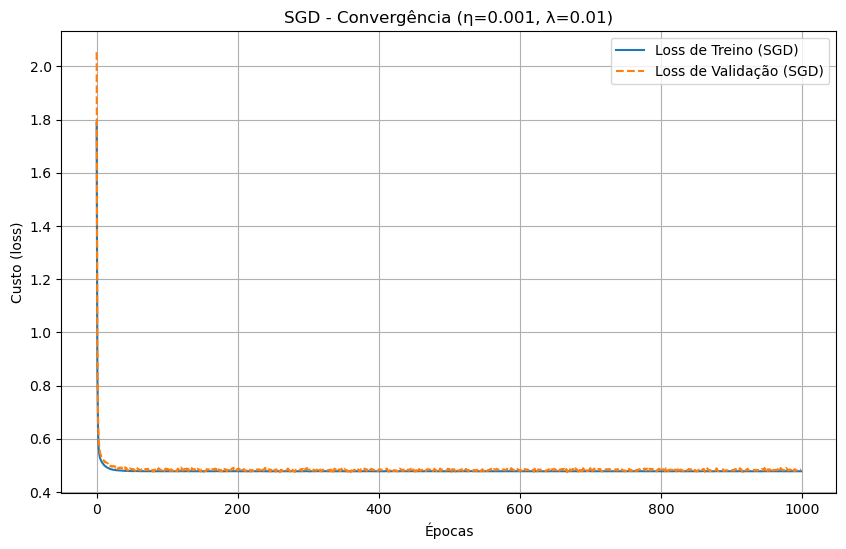

In [57]:
#############################################
# 9.2. Gráfico de Convergência Completo (SGD)
#############################################

plt.figure(figsize=(10, 6))
plt.plot(custos_treino_sgd, label="Loss de Treino (SGD)")
plt.plot(custos_validacao_sgd, label="Loss de Validação (SGD)", linestyle='--')

plt.title(f"SGD - Convergência (η={taxa_sgd}, λ={lambda_sgd})")
plt.xlabel("Épocas")
plt.ylabel("Custo (loss)")
plt.legend()
plt.grid(True)
plt.show()

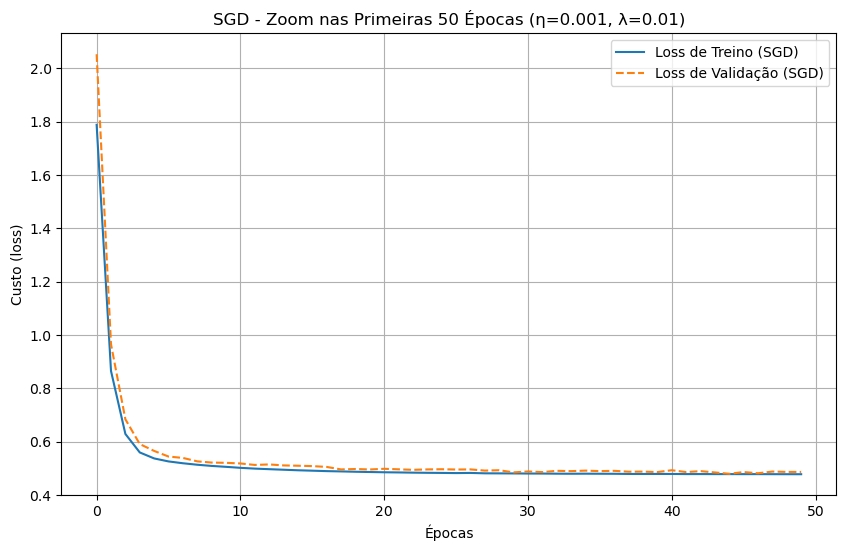

In [58]:
##################################################
# 9.3. Gráfico com Zoom nas Primeiras Épocas (SGD)
##################################################

epocas_zoom = 50 

plt.figure(figsize=(10, 6))
plt.plot(range(epocas_zoom), custos_treino_sgd[:epocas_zoom],
         label="Loss de Treino (SGD)")
plt.plot(range(epocas_zoom), custos_validacao_sgd[:epocas_zoom],
         label="Loss de Validação (SGD)", linestyle='--')

plt.title(f"SGD - Zoom nas Primeiras {epocas_zoom} Épocas (η={taxa_sgd}, λ={lambda_sgd})")
plt.xlabel("Épocas")
plt.ylabel("Custo (loss)")
plt.legend()
plt.grid(True)
plt.show()

In [59]:
####################################################
# 10. Treino com Gradiente Descendente em Mini-Batch
####################################################

def gradiente_descendente_minibatch(X_treino, y_treino,
                                    X_validacao, y_validacao,
                                    taxa_aprendizagem, lambda_reg,
                                    n_epocas, tamanho_batch=32):
    """
    Treina um modelo de regressão linear usando o Gradiente Descendente em Mini-Batch.

    Em cada época:
      - os dados de treino são baralhados;
      - o treino é dividido em mini-batches de tamanho fixo;
      - para cada mini-batch calcula-se o gradiente médio e atualizam-se W e b;
      - no final da época calcula-se o custo no treino e na validação.

    O método Mini-Batch combina:
      - a estabilidade do Batch GD (usar muitos exemplos por atualização)
      - com a rapidez do SGD (várias atualizações por época).

    Argumentos:
        X_treino         – matriz de treino (n_exemplos, n_atributos)
        y_treino         – vetor alvo de treino
        X_validacao      – matriz de validação
        y_validacao      – vetor alvo de validação
        taxa_aprendizagem – taxa de aprendizagem (η)
        lambda_reg       – regularização L2 (λ)
        n_epocas         – número total de épocas
        tamanho_batch    – número de exemplos por mini-batch

    Retorna:
        pesos_W          – pesos finais treinados
        vies_b           – viés final treinado
        custos_treino    – lista dos custos de treino por época
        custos_validacao – lista dos custos de validação por época
    """

    n_exemplos, n_atributos = X_treino.shape

    # Inicialização dos parâmetros
    pesos_W = np.random.randn(n_atributos, 1) * 0.01
    vies_b = 0.0

    custos_treino = []
    custos_validacao = []

    print(f"Iniciar Mini-Batch com η={taxa_aprendizagem}, λ={lambda_reg}, "
          f"épocas={n_epocas}, batch={tamanho_batch}")

    # Ciclo principal de treino
    for epoca in range(n_epocas):

        # 1) Baralhar os dados no início de cada época
        indices_baralhados = np.random.permutation(n_exemplos)
        X_treino_baralhado = X_treino[indices_baralhados]
        y_treino_baralhado = y_treino[indices_baralhados]

        # 2) Número de mini-batches nesta época
        n_batches = int(np.ceil(n_exemplos / tamanho_batch))

        # 3) Percorrer cada mini-batch
        for i in range(n_batches):
            inicio = i * tamanho_batch
            fim = min((i + 1) * tamanho_batch, n_exemplos)

            X_batch = X_treino_baralhado[inicio:fim]
            y_batch = y_treino_baralhado[inicio:fim]

            # Gradientes para um mini-batch
            grad_W, grad_b = calcular_gradientes(
                X_batch, y_batch,
                pesos_W, vies_b,
                lambda_reg
            )

            # Atualizar parâmetros
            pesos_W = pesos_W - taxa_aprendizagem * grad_W
            vies_b  = vies_b  - taxa_aprendizagem * grad_b

        # 4) No fim da época, calcular custos globais
        custo_treino = calcular_custo(X_treino, y_treino, pesos_W, vies_b, lambda_reg)
        custo_validacao = calcular_custo(X_validacao, y_validacao, pesos_W, vies_b, lambda_reg)

        custos_treino.append(custo_treino)
        custos_validacao.append(custo_validacao)

        if epoca % 100 == 0 or epoca == n_epocas - 1:
            print(f"Época {epoca+1}/{n_epocas} | "
                  f"Loss Treino: {custo_treino:.4f} | "
                  f"Loss Validação: {custo_validacao:.4f}")

    print("Treino Mini-Batch concluído.\n")

    return pesos_W, vies_b, custos_treino, custos_validacao

In [60]:
########################################
# 10.1. Executar o Treino com Mini-Batch
########################################

taxa_minibatch = 0.001       # taxa de aprendizagem
epocas_minibatch = 1000      # número de épocas
lambda_minibatch = 0.01      # regularização L2
tamanho_batch = 32           # tamanho do mini-batch

pesos_W_mini, vies_b_mini, custos_treino_mini, custos_validacao_mini = gradiente_descendente_minibatch(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_minibatch, lambda_minibatch,
    epocas_minibatch, tamanho_batch
)

print("Resultados finais Mini-Batch:")
print("  Primeiros 3 pesos:", pesos_W_mini[:3].flatten())
print(f"  Viés (b): {vies_b_mini:.4f}")

Iniciar Mini-Batch com η=0.001, λ=0.01, épocas=1000, batch=32
Época 1/1000 | Loss Treino: 5.3056 | Loss Validação: 6.1500
Época 101/1000 | Loss Treino: 0.6092 | Loss Validação: 0.6517
Época 201/1000 | Loss Treino: 0.5236 | Loss Validação: 0.5392
Época 301/1000 | Loss Treino: 0.5071 | Loss Validação: 0.5204
Época 401/1000 | Loss Treino: 0.4976 | Loss Validação: 0.5101
Época 501/1000 | Loss Treino: 0.4915 | Loss Validação: 0.5034
Época 601/1000 | Loss Treino: 0.4875 | Loss Validação: 0.4987
Época 701/1000 | Loss Treino: 0.4849 | Loss Validação: 0.4953
Época 801/1000 | Loss Treino: 0.4830 | Loss Validação: 0.4927
Época 901/1000 | Loss Treino: 0.4817 | Loss Validação: 0.4907
Época 1000/1000 | Loss Treino: 0.4808 | Loss Validação: 0.4892
Treino Mini-Batch concluído.

Resultados finais Mini-Batch:
  Primeiros 3 pesos: [ 0.77786215  0.1354671  -0.09717018]
  Viés (b): 2.0578


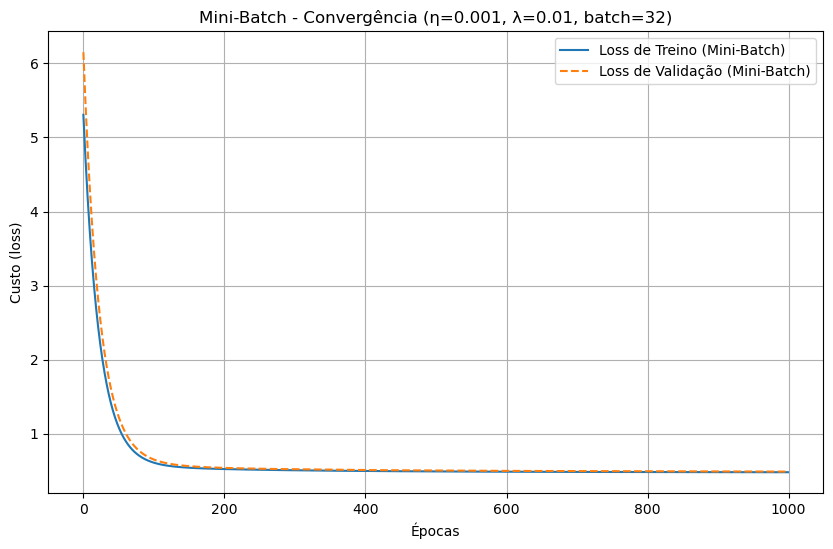

In [61]:
#####################################################
# 10.2. Gráfico de Convergência Completo (Mini-Batch)
#####################################################

plt.figure(figsize=(10, 6))
plt.plot(custos_treino_mini, label="Loss de Treino (Mini-Batch)")
plt.plot(custos_validacao_mini, label="Loss de Validação (Mini-Batch)", linestyle='--')

plt.title(f"Mini-Batch - Convergência (η={taxa_minibatch}, λ={lambda_minibatch}, batch={tamanho_batch})")
plt.xlabel("Épocas")
plt.ylabel("Custo (loss)")
plt.legend()
plt.grid(True)
plt.show()


>>> Testar diferentes taxas de aprendizagem (η)...
Iniciar Mini-Batch com η=0.01, λ=0.01, épocas=1000, batch=32
Época 1/1000 | Loss Treino: 3.7284 | Loss Validação: 4.3109
Época 101/1000 | Loss Treino: 0.4808 | Loss Validação: 0.4912
Época 201/1000 | Loss Treino: 0.4782 | Loss Validação: 0.4830
Época 301/1000 | Loss Treino: 0.4779 | Loss Validação: 0.4828
Época 401/1000 | Loss Treino: 0.4779 | Loss Validação: 0.4833
Época 501/1000 | Loss Treino: 0.4778 | Loss Validação: 0.4816
Época 601/1000 | Loss Treino: 0.4779 | Loss Validação: 0.4808
Época 701/1000 | Loss Treino: 0.4779 | Loss Validação: 0.4824
Época 801/1000 | Loss Treino: 0.4778 | Loss Validação: 0.4821
Época 901/1000 | Loss Treino: 0.4778 | Loss Validação: 0.4823
Época 1000/1000 | Loss Treino: 0.4778 | Loss Validação: 0.4824
Treino Mini-Batch concluído.

Iniciar Mini-Batch com η=0.001, λ=0.01, épocas=1000, batch=32
Época 1/1000 | Loss Treino: 5.3053 | Loss Validação: 6.1473
Época 101/1000 | Loss Treino: 0.6089 | Loss Validação:

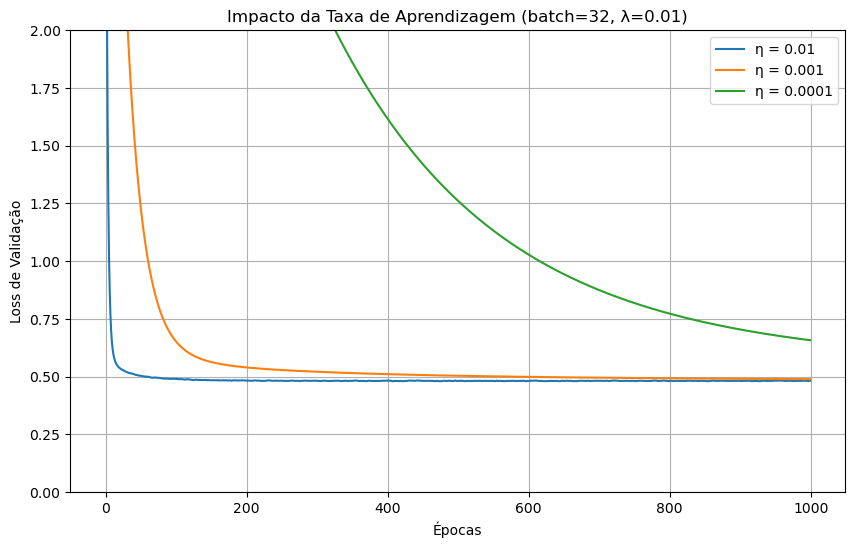

In [62]:
#########################################
# 11. Impacto da Taxa de Aprendizagem (η)
#########################################

print("\n>>> Testar diferentes taxas de aprendizagem (η)...")

# Valores base (usados quando não estamos a testar o parâmetro)
taxa_base = 0.001
lambda_base = 0.01
batch_base = 32
epocas_base = 1000   # menos épocas para os testes serem mais rápidos

taxas_testar = [0.01, 0.001, 0.0001]

plt.figure(figsize=(10, 6))

for taxa in taxas_testar:
    # Treinar sempre com Mini-Batch GD, só mudando a taxa de aprendizagem
    _, _, _, custos_validacao_exp = gradiente_descendente_minibatch(
        X_treino_norm, y_treino,
        X_validacao_norm, y_validacao,
        taxa_aprendizagem=taxa,
        lambda_reg=lambda_base,
        n_epocas=epocas_base,
        tamanho_batch=batch_base
    )

    plt.plot(custos_validacao_exp, label=f"η = {taxa}")

plt.title(f"Impacto da Taxa de Aprendizagem (batch={batch_base}, λ={lambda_base})")
plt.xlabel("Épocas")
plt.ylabel("Loss de Validação")
plt.legend()
plt.grid(True)
plt.ylim(0, 2)  # ajuda a focar na zona relevante
plt.show()


>>> Testar diferentes tamanhos de mini-batch
Iniciar Mini-Batch com η=0.001, λ=0.01, épocas=1000, batch=16
Época 1/1000 | Loss Treino: 5.0993 | Loss Validação: 5.9087
Época 101/1000 | Loss Treino: 0.5236 | Loss Validação: 0.5399
Época 201/1000 | Loss Treino: 0.4978 | Loss Validação: 0.5110
Época 301/1000 | Loss Treino: 0.4877 | Loss Validação: 0.4994
Época 401/1000 | Loss Treino: 0.4832 | Loss Validação: 0.4932
Época 501/1000 | Loss Treino: 0.4809 | Loss Validação: 0.4894
Época 601/1000 | Loss Treino: 0.4797 | Loss Validação: 0.4872
Época 701/1000 | Loss Treino: 0.4790 | Loss Validação: 0.4856
Época 801/1000 | Loss Treino: 0.4786 | Loss Validação: 0.4845
Época 901/1000 | Loss Treino: 0.4783 | Loss Validação: 0.4837
Época 1000/1000 | Loss Treino: 0.4782 | Loss Validação: 0.4830
Treino Mini-Batch concluído.

Iniciar Mini-Batch com η=0.001, λ=0.01, épocas=1000, batch=32
Época 1/1000 | Loss Treino: 5.3229 | Loss Validação: 6.1738
Época 101/1000 | Loss Treino: 0.6113 | Loss Validação: 0.65

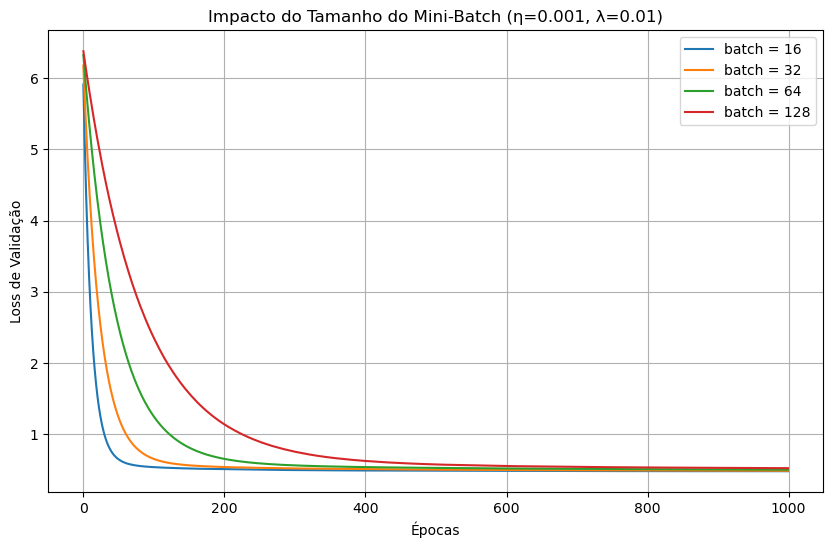

In [63]:
######################################
# 12. Impacto do Tamanho do Mini-Batch
######################################

print("\n>>> Testar diferentes tamanhos de mini-batch")

tamanhos_batch_testar = [16, 32, 64, 128]

plt.figure(figsize=(10, 6))

for tam_batch in tamanhos_batch_testar:
    _, _, _, custos_validacao_exp = gradiente_descendente_minibatch(
        X_treino_norm, y_treino,
        X_validacao_norm, y_validacao,
        taxa_aprendizagem=taxa_base,
        lambda_reg=lambda_base,
        n_epocas=epocas_base,
        tamanho_batch=tam_batch
    )

    plt.plot(custos_validacao_exp, label=f"batch = {tam_batch}")

plt.title(f"Impacto do Tamanho do Mini-Batch (η={taxa_base}, λ={lambda_base})")
plt.xlabel("Épocas")
plt.ylabel("Loss de Validação")
plt.legend()
plt.grid(True)
plt.show()


>>> Analisar a convergência ao longo de muitas épocas
Iniciar Mini-Batch com η=0.001, λ=0.01, épocas=2000, batch=32
Época 1/2000 | Loss Treino: 5.3056 | Loss Validação: 6.1397
Época 101/2000 | Loss Treino: 0.6081 | Loss Validação: 0.6510
Época 201/2000 | Loss Treino: 0.5230 | Loss Validação: 0.5391
Época 301/2000 | Loss Treino: 0.5069 | Loss Validação: 0.5205
Época 401/2000 | Loss Treino: 0.4975 | Loss Validação: 0.5104
Época 501/2000 | Loss Treino: 0.4915 | Loss Validação: 0.5037
Época 601/2000 | Loss Treino: 0.4875 | Loss Validação: 0.4989
Época 701/2000 | Loss Treino: 0.4849 | Loss Validação: 0.4955
Época 801/2000 | Loss Treino: 0.4831 | Loss Validação: 0.4929
Época 901/2000 | Loss Treino: 0.4818 | Loss Validação: 0.4909
Época 1001/2000 | Loss Treino: 0.4808 | Loss Validação: 0.4892
Época 1101/2000 | Loss Treino: 0.4802 | Loss Validação: 0.4880
Época 1201/2000 | Loss Treino: 0.4797 | Loss Validação: 0.4870
Época 1301/2000 | Loss Treino: 0.4793 | Loss Validação: 0.4861
Época 1401/20

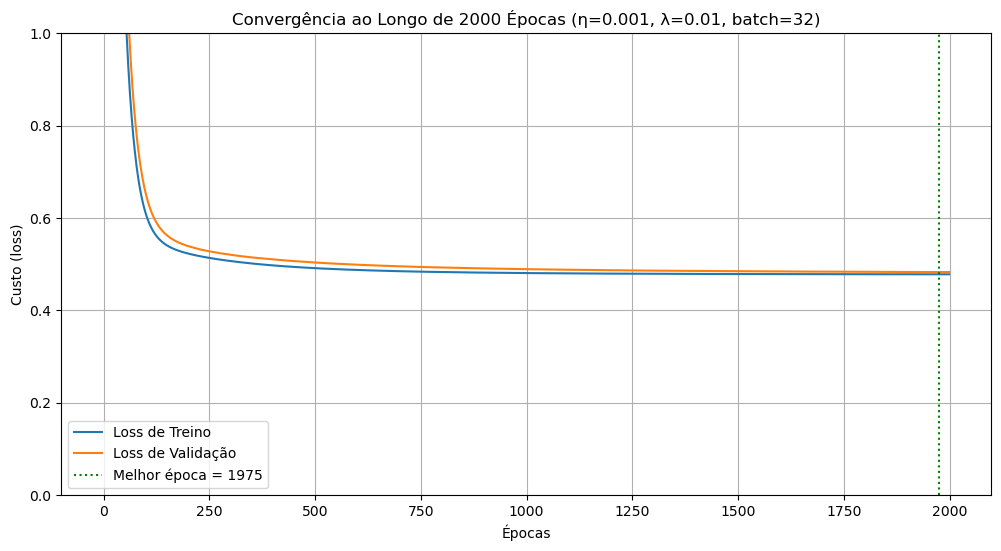

In [64]:
#################################
# 13. Analisar o Número de Épocas
#################################

print("\n>>> Analisar a convergência ao longo de muitas épocas")

epocas_long_run = 2000
taxa_long_run = taxa_base
batch_long_run = batch_base
lambda_long_run = lambda_base

# Treino longo com Mini-Batch
_, _, custos_treino_long, custos_validacao_long = gradiente_descendente_minibatch(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_aprendizagem=taxa_long_run,
    lambda_reg=lambda_long_run,
    n_epocas=epocas_long_run,
    tamanho_batch=batch_long_run
)

# Encontrar a melhor época (menor loss de validação)
indice_melhor_epoca = np.argmin(custos_validacao_long)
melhor_epoca = indice_melhor_epoca + 1
melhor_loss_val = custos_validacao_long[indice_melhor_epoca]

print(f"\nAnálise do Número de Épocas:")
print(f"  Melhor loss de validação = {melhor_loss_val:.4f} na época {melhor_epoca}")

# Gráfico com indicação da melhor época
plt.figure(figsize=(12, 6))
plt.plot(custos_treino_long, label="Loss de Treino")
plt.plot(custos_validacao_long, label="Loss de Validação")

plt.axvline(x=melhor_epoca, color='green', linestyle=':',
            label=f"Melhor época = {melhor_epoca}")

plt.title(f"Convergência ao Longo de {epocas_long_run} Épocas "
          f"(η={taxa_long_run}, λ={lambda_long_run}, batch={batch_long_run})")
plt.xlabel("Épocas")
plt.ylabel("Custo (loss)")
plt.legend()
plt.grid(True)
plt.ylim(0, 1.0)
plt.show()


>>> Testar diferentes valores de regularização (λ)
Iniciar Mini-Batch com η=0.001, λ=0.0, épocas=1000, batch=32
Época 1/1000 | Loss Treino: 5.3189 | Loss Validação: 6.1642
Época 101/1000 | Loss Treino: 0.6022 | Loss Validação: 0.6446
Época 201/1000 | Loss Treino: 0.5135 | Loss Validação: 0.5302
Época 301/1000 | Loss Treino: 0.4945 | Loss Validação: 0.5089
Época 401/1000 | Loss Treino: 0.4828 | Loss Validação: 0.4962
Época 501/1000 | Loss Treino: 0.4750 | Loss Validação: 0.4873
Época 601/1000 | Loss Treino: 0.4697 | Loss Validação: 0.4808
Época 701/1000 | Loss Treino: 0.4661 | Loss Validação: 0.4760
Época 801/1000 | Loss Treino: 0.4636 | Loss Validação: 0.4722
Época 901/1000 | Loss Treino: 0.4618 | Loss Validação: 0.4692
Época 1000/1000 | Loss Treino: 0.4605 | Loss Validação: 0.4667
Treino Mini-Batch concluído.

Iniciar Mini-Batch com η=0.001, λ=0.01, épocas=1000, batch=32
Época 1/1000 | Loss Treino: 5.3087 | Loss Validação: 6.1661
Época 101/1000 | Loss Treino: 0.6110 | Loss Validação:

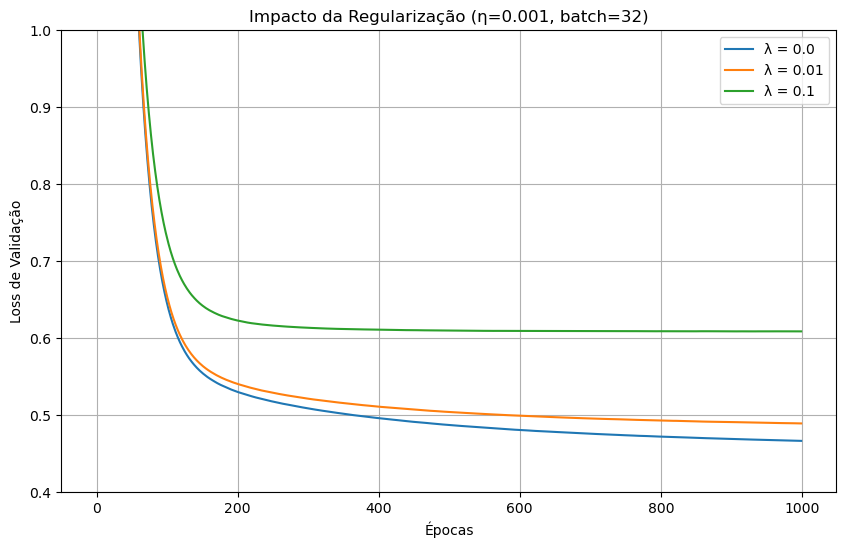

In [65]:
###############################################################
# 14. Impacto da Regularização (λ)
###############################################################

print("\n>>> Testar diferentes valores de regularização (λ)")

lambdas_testar = [0.0, 0.01, 0.1]

plt.figure(figsize=(10, 6))

for lam in lambdas_testar:
    _, _, _, custos_validacao_exp = gradiente_descendente_minibatch(
        X_treino_norm, y_treino,
        X_validacao_norm, y_validacao,
        taxa_aprendizagem=taxa_base,
        lambda_reg=lam,
        n_epocas=epocas_base,
        tamanho_batch=batch_base
    )

    plt.plot(custos_validacao_exp, label=f"λ = {lam}")

plt.title(f"Impacto da Regularização (η={taxa_base}, batch={batch_base})")
plt.xlabel("Épocas")
plt.ylabel("Loss de Validação")
plt.legend()
plt.grid(True)
plt.ylim(0.4, 1.0)
plt.show()

In [66]:
###########################################
# 15. Comparação Final no Conjunto de Teste
###########################################

print("\n Comparação Final no Conjunto de Teste")

# Hiperparâmetros "escolhidos" (com base na Tarefa 3)
epocas_finais = 2000
lambda_final = 0.01

eta_bgd_final = 0.01    # No BGD é comum usar taxas de aprendizagem maiores
eta_sgd_final = 0.001   # No SGD a taxa de aprendizagem deve ser mais pequena
eta_mini_final = 0.001  # Valor típico e estável no Mini-Batch
batch_final = 32

print(f"\nTreinar modelos finais durante {epocas_finais} épocas...\n")

# 1) Treino final com BGD
pesos_W_bgd_final, vies_b_bgd_final, _, _ = gradiente_descendente_batch(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_aprendizagem=eta_bgd_final,
    lambda_reg=lambda_final,
    n_epocas=epocas_finais
)

# 2) Treino final com SGD
pesos_W_sgd_final, vies_b_sgd_final, _, _ = gradiente_descendente_estocastico(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_aprendizagem=eta_sgd_final,
    lambda_reg=lambda_final,
    n_epocas=epocas_finais
)

# 3) Treino final com Mini-Batch
pesos_W_mini_final, vies_b_mini_final, _, _ = gradiente_descendente_minibatch(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_aprendizagem=eta_mini_final,
    lambda_reg=lambda_final,
    n_epocas=epocas_finais,
    tamanho_batch=batch_final
)

# --- Calcular o erro final no conjunto de TESTE ---
# Aqui usamos lambda_reg = 0 para medir só o MSE (sem penalização L2)
mse_teste_bgd = calcular_custo(X_teste_norm, y_teste, pesos_W_bgd_final,  vies_b_bgd_final,  lambda_reg=0)
mse_teste_sgd = calcular_custo(X_teste_norm, y_teste, pesos_W_sgd_final,  vies_b_sgd_final,  lambda_reg=0)
mse_teste_mini = calcular_custo(X_teste_norm, y_teste, pesos_W_mini_final, vies_b_mini_final, lambda_reg=0)

print("\n===================================================")
print(f"{'MÉTODO':<15} | {'MSE no Teste':<15}")
print("---------------------------------------------------")
print(f"{'BGD':<15} | {mse_teste_bgd:.5f}")
print(f"{'SGD':<15} | {mse_teste_sgd:.5f}")
print(f"{'Mini-Batch':<15} | {mse_teste_mini:.5f}")
print("===================================================\n")


 Comparação Final no Conjunto de Teste

Treinar modelos finais durante 2000 épocas...

Iniciar BGD com η=0.01, λ=0.01, épocas=2000
Época 1/2000 | Loss Treino: 5.4589 | Loss Validação: 6.3331
Época 101/2000 | Loss Treino: 1.2198 | Loss Validação: 1.3855
Época 201/2000 | Loss Treino: 0.6439 | Loss Validação: 0.6955
Época 301/2000 | Loss Treino: 0.5523 | Loss Validação: 0.5775
Época 401/2000 | Loss Treino: 0.5298 | Loss Validação: 0.5472
Época 501/2000 | Loss Treino: 0.5191 | Loss Validação: 0.5340
Época 601/2000 | Loss Treino: 0.5117 | Loss Validação: 0.5257
Época 701/2000 | Loss Treino: 0.5059 | Loss Validação: 0.5195
Época 801/2000 | Loss Treino: 0.5013 | Loss Validação: 0.5146
Época 901/2000 | Loss Treino: 0.4976 | Loss Validação: 0.5105
Época 1001/2000 | Loss Treino: 0.4945 | Loss Validação: 0.5072
Época 1101/2000 | Loss Treino: 0.4920 | Loss Validação: 0.5043
Época 1201/2000 | Loss Treino: 0.4899 | Loss Validação: 0.5019
Época 1301/2000 | Loss Treino: 0.4882 | Loss Validação: 0.499


=== Efeito da Normalização dos Dados ===

Treino com dados NORMALIZADOS...
Iniciar Mini-Batch com η=0.001, λ=0.01, épocas=500, batch=32
Época 1/500 | Loss Treino: 5.3184 | Loss Validação: 6.2023
Época 101/500 | Loss Treino: 0.6104 | Loss Validação: 0.6544
Época 201/500 | Loss Treino: 0.5247 | Loss Validação: 0.5415
Época 301/500 | Loss Treino: 0.5081 | Loss Validação: 0.5223
Época 401/500 | Loss Treino: 0.4984 | Loss Validação: 0.5119
Época 500/500 | Loss Treino: 0.4922 | Loss Validação: 0.5050
Treino Mini-Batch concluído.

Treino com dados ORIGINAIS (sem normalização)...
Iniciar Mini-Batch com η=1e-07, λ=0.01, épocas=500, batch=32
Época 1/500 | Loss Treino: 8.8234 | Loss Validação: 8.4745
Época 101/500 | Loss Treino: 1.8707 | Loss Validação: 2.0343
Época 201/500 | Loss Treino: 1.3150 | Loss Validação: 1.5061
Época 301/500 | Loss Treino: 1.3233 | Loss Validação: 1.4918
Época 401/500 | Loss Treino: 1.2816 | Loss Validação: 1.4190
Época 500/500 | Loss Treino: 1.3052 | Loss Validação: 1.

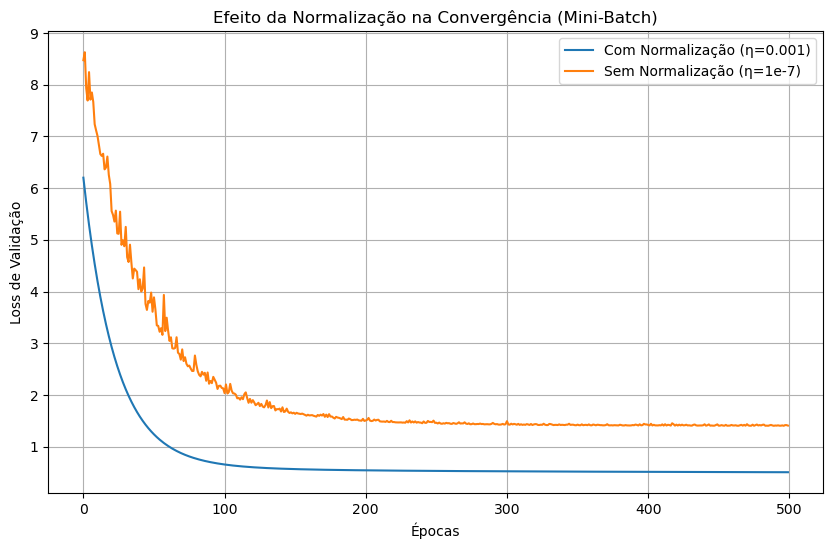

In [67]:
######################################
# 16. Efeito da Normalização dos Dados
######################################

print("\n=== Efeito da Normalização dos Dados ===")

# Caso 1 – Com normalização (já sabemos que funciona bem com η ≈ 0.001)
print("\nTreino com dados NORMALIZADOS...")
_, _, _, custos_validacao_norm = gradiente_descendente_minibatch(
    X_treino_norm, y_treino,
    X_validacao_norm, y_validacao,
    taxa_aprendizagem=0.001,
    lambda_reg=0.01,
    n_epocas=500,
    tamanho_batch=32
)

# Caso 2 – Sem normalização
# Precisamos de uma taxa de aprendizagem MUITO menor para não "explodir"
print("Treino com dados ORIGINAIS (sem normalização)...")
_, _, _, custos_validacao_sem_norm = gradiente_descendente_minibatch(
    X_treino, y_treino,           # dados originais
    X_validacao, y_validacao,     # dados originais
    taxa_aprendizagem=1e-7,       # η minúsculo
    lambda_reg=0.01,
    n_epocas=500,
    tamanho_batch=32
)

# Gráfico de comparação
plt.figure(figsize=(10, 6))
plt.plot(custos_validacao_norm, label="Com Normalização (η=0.001)")
plt.plot(custos_validacao_sem_norm, label="Sem Normalização (η=1e-7)")

plt.title("Efeito da Normalização na Convergência (Mini-Batch)")
plt.xlabel("Épocas")
plt.ylabel("Loss de Validação")
plt.legend()
plt.grid(True)
plt.show()

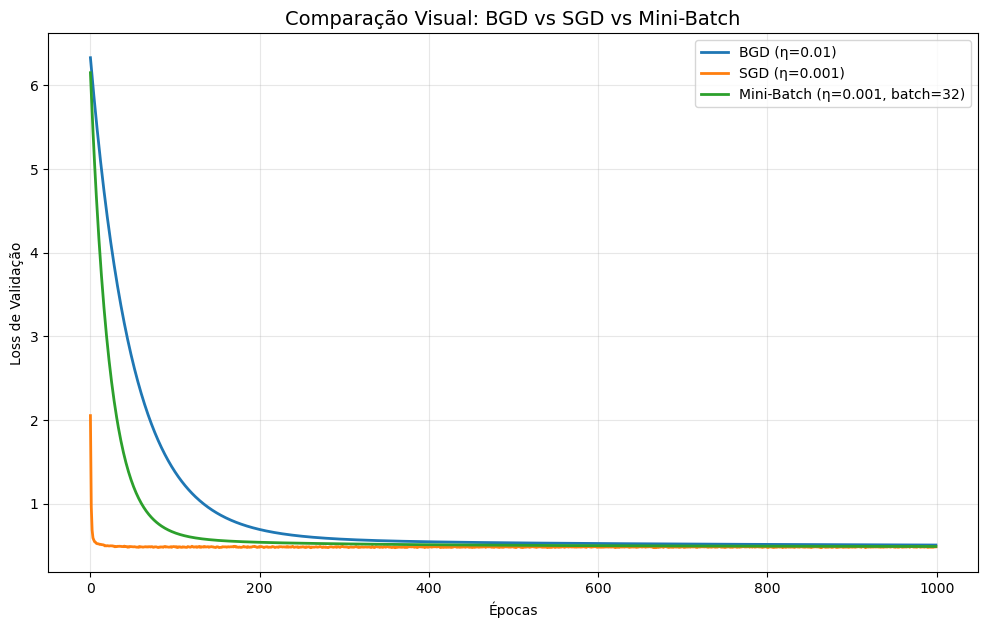

In [68]:
################################################
# 17. Comparação Visual dos Três Métodos de GD
################################################

plt.figure(figsize=(12, 7))

# Curva do BGD
plt.plot(custos_validacao_bgd, 
         label=f"BGD (η={eta_bgd_final})", 
         linewidth=2)

# Curva do SGD
plt.plot(custos_validacao_sgd, 
         label=f"SGD (η={eta_sgd_final})", 
         linewidth=2)

# Curva do Mini-Batch
plt.plot(custos_validacao_mini, 
         label=f"Mini-Batch (η={eta_mini_final}, batch={batch_final})", 
         linewidth=2)

plt.title("Comparação Visual: BGD vs SGD vs Mini-Batch", fontsize=14)
plt.xlabel("Épocas")
plt.ylabel("Loss de Validação")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()